In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import os

**Load Data**

In [3]:
train_data = pd.read_csv('../input/train.csv')


In [5]:
train_X = train_data.drop(['id', 'target'], axis = 1)
train_Y = train_data['target']

In [6]:
test_data = pd.read_csv('../input/test.csv')

In [7]:
test_data_X = test_data.drop(['id'], axis = 1)

**Preprocess the Data**

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_data_X = sc.fit_transform(test_data_X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_Y, test_size=0.20, random_state=111)

Machine Learning

In [10]:
# import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import regularizers
from keras.constraints import max_norm


Using TensorFlow backend.


In [16]:
import tensorflow as tf
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc




In [17]:
# Initialize the NN 
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1] , activation='tanh', 
                kernel_initializer = "normal", kernel_regularizer=regularizers.l2(0.005), 
                kernel_constraint = max_norm(5.)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.005)
                , kernel_constraint=max_norm(5)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.005)
                , kernel_constraint=max_norm(5)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.005)
                , kernel_constraint=max_norm(5)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
__________

In [26]:
checkpoint = ModelCheckpoint('rc_model', monitor='val_auc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_delta=0.001)
# early stopping
earlyStoping = EarlyStopping(monitor='val_auc', 
                                  patience=9, mode='max', verbose=1)

callbacks_list = [checkpoint, reduceLROnPlat, earlyStoping]

In [28]:
# fit model
history = model.fit(X_train, Y_train, batch_size = 256, epochs=50, validation_split=0.20,
                    validation_data=(X_test, Y_test), callbacks=callbacks_list)

Train on 209715 samples, validate on 52429 samples
Epoch 1/1
209715/209715 [==============================] - 12s 58us/step - loss: 0.7031 - auc: 0.5104 - val_loss: 0.7048 - val_auc: 0.5102

Epoch 00001: val_auc did not improve from 0.51035


In [29]:
_, train_auc = model.evaluate(X_train, Y_train, verbose=0)
print(train_auc)

0.5104597821215306


In [31]:
_, test_auc = model.evaluate(X_test, Y_test, verbose=0)
print(test_auc)

0.5108304400669949


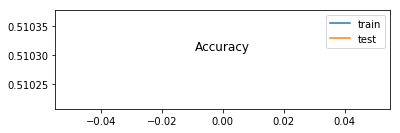

In [33]:
# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show()

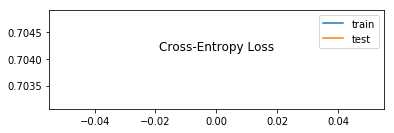

In [34]:
# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
preds = model.predict(test_data_X)

In [ ]:
# make submission
submission = pd.DataFrame({"id" : test_data['id'].values,
                           "target" : preds[:,0]})
submission.to_csv('submission.csv', index = False, header = True)
display(submission.head(15))
display(submission.tail(15))